In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
 
from tqdm import tqdm_notebook as tqdm
from time import sleep
from IPython import embed
 
%reload_ext autoreload
%autoreload 2

In [18]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parents[0]))
import time
import datetime

from models import *
from utils.utils import *
from utils.datasets import *

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

In [19]:
config_path = "../config/mymodel.cfg"
weights_path = "../result/normal_finetuning_aug_full_strong/35.pkl"
# weights_path = "../weights/yolov3-tiny.weights"
image_folder = "../data/mydata/test_images/"
img_size = 416
batchsize = 1
class_path = "../data/coco.names"
conf_thresh = 0.7
nms_thres = 0.4

In [20]:
classes = load_classes(class_path)
Tensor = torch.FloatTensor

In [21]:
model = Darknet(config_path, img_size=img_size)
model_wts = torch.load(weights_path, map_location='cpu')
model.load_state_dict(model_wts)

In [25]:
dataloader = DataLoader(ImageFolder(image_folder, img_size=img_size),
                        batch_size=1, shuffle=False, num_workers=0)
dataloader = iter(dataloader)
n_show = 8

imgs = []           # Stores image paths
img_detections = [] # Stores detections for each image index

inference_times = []
for i in tqdm(range(n_show)): 
    img_paths, input_imgs =  next(dataloader)
  
    t_start = time.time()
    
    # Configure input
    input_imgs = Variable(input_imgs.type(Tensor))

    # Get detections
    with torch.no_grad():
        detections = model(input_imgs)
        detections = non_max_suppression(detections, 80, conf_thresh, nms_thres)

    # Log progress
    t_end = time.time()
    inference_times.append(t_end - t_start)

    # Save image and detections
    imgs.extend(img_paths)
    img_detections.extend(detections)

print("inference time:", np.mean(inference_times))

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))


inference time: 1.0888816714286804


In [26]:
from PIL import Image
from chainercv.visualizations import vis_bbox

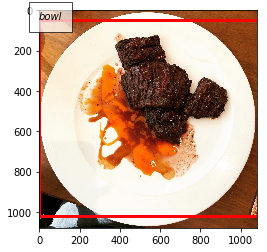

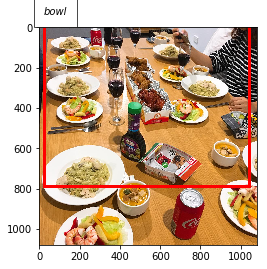

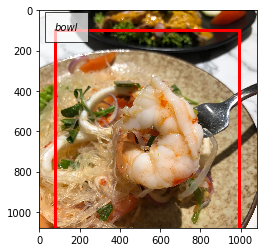

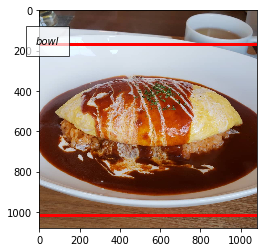

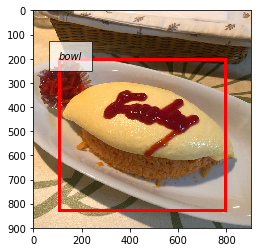

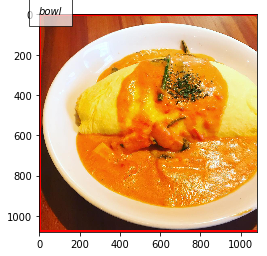

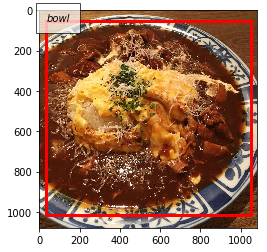

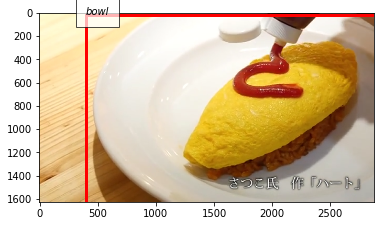

In [27]:
for img_path, labels in zip(imgs, img_detections):  
    img = np.array(Image.open(img_path))
    img_h, img_w, _ = img.shape

    if labels is None:
        plt.imshow(img)
        plt.show()
        continue
    
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape)) 
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    
    cv_img = img.transpose(2, 0, 1)
    cv_bboxes, cv_labels = [], []
    
    max_size_bbox = []
    max_s = 0
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in labels:
        h = ((y2 - y1) / unpad_h) * img_h
        w = ((x2 - x1) / unpad_w) * img_w
        ty = ((y1 - pad_y // 2) / unpad_h) * img_h
        tx = ((x1 - pad_x // 2) / unpad_w) * img_w
        
#         cv_bboxes.append([ty, tx, ty+h, tx+w])
#         cv_labels.append(int(cls_pred))
        
        if int(cls_pred) == 45 and h*w > max_s and  h*w <= img_h*1.2*img_w:
            max_size_bbox = [ty, tx, ty+h, tx+w]
            max_s = h*w
       
    cv_bboxes.append(max_size_bbox)
    cv_labels.append(45)
    
    vis_bbox(cv_img, cv_bboxes, cv_labels, label_names=classes)
    plt.show()